# Lib

In [2]:
!pip install -q flwr[simulation]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 25.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 34.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.7 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires go

In [ ]:
!pip install deepbrain -q

In [3]:
# Standard libraries
import os
import warnings
import math
import random
from pathlib import Path
from collections import Counter, OrderedDict
from typing import List, Tuple, Dict, Optional, Union, Callable
from enum import IntEnum
import json

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm import tqdm
from ipywidgets import interact

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# Torchvision
import torchvision.transforms as transforms

# Flower
import flwr
from flwr.client import Client, ClientApp
from flwr.common import (
    Code, EvaluateIns, EvaluateRes, FitIns, FitRes, GetParametersIns, GetParametersRes,
    Status, Parameters, Scalar, NDArray, NDArrays, ndarrays_to_parameters, parameters_to_ndarrays, Context
)
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from flwr.simulation import run_simulation

# HuggingFace Datasets
from datasets.utils.logging import disable_progress_bar, set_verbosity_error

2025-05-27 14:32:15.407347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748356335.603498      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748356335.661946      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setup

In [4]:
# Thiết lập thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
set_verbosity_error()
warnings.filterwarnings("ignore")

# Định nghĩa drop out
class CustomCode(IntEnum):
    DROPPED_OUT = 100

Training on cuda
Flower 1.18.0 / PyTorch 2.5.1+cu124


In [5]:
# config
NUM_CLIENTS = 10
NUM_ROUNDS = 30
DROPOUT = 0.1
BATCHSIZE = 128
OVERLAP = 0.6
LR = 0.001
epochs_round = 1

# Prepare Data

In [5]:
im = nib.load('/kaggle/input/mri-dataset/not_skull_stripped/sub-BrainAge000000/anat/sub-BrainAge000000_T1w.nii/sub-BrainAge000000_T1w.nii')
data = im.get_fdata()
data.shape, im.affine, im.header

((130, 130, 130),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 <nibabel.nifti1.Nifti1Header at 0x78bbcad4ab90>)

In [ ]:
import plotly.graph_objects as go

# Load MRI data
img = nib.load('/kaggle/input/mri-dataset/not_skull_stripped/sub-BrainAge000000/anat/sub-BrainAge000000_T1w.nii/sub-BrainAge000000_T1w.nii')
data = img.get_fdata()

# Normalize to [0, 1]
data = (data - np.min(data)) / (np.max(data) - np.min(data))

data = data[30:130, 30:130, 30:130]

# Apply threshold for visualization (keep only high intensity)
threshold = 0.4
x, y, z = np.where(data > threshold)
intensity = data[x, y, z]

# Create 3D scatter plot
fig = go.Figure(data=go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=1.5,
        color=intensity,
        colorscale='Viridis',
        opacity=0.1
    )
))

fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
    ),
    title="3D MRI Volume",
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()

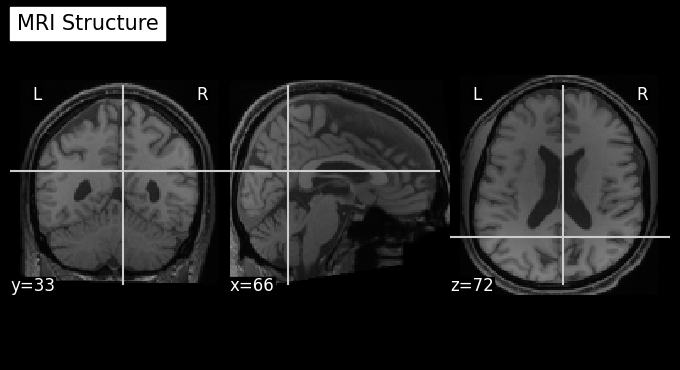

In [6]:
from nilearn import plotting

plotting.plot_anat(
    '/kaggle/input/mri-dataset/not_skull_stripped/sub-BrainAge000000/anat/sub-BrainAge000000_T1w.nii/sub-BrainAge000000_T1w.nii',
    display_mode='ortho',  # hiển thị 3 chiều: axial, sagittal, coronal
    title='MRI Structure',
    annotate=True,
    draw_cross=True
)
plotting.show()


In [3]:
def show_slice(slice_index):
    plt.imshow(data[:, :, slice_index], cmap='gray')
    plt.title(f"Axial Slice {slice_index}")
    plt.axis('off')
    plt.show()

interact(show_slice, slice_index=(0, data.shape[2] - 1));

interactive(children=(IntSlider(value=64, description='slice_index', max=129), Output()), _dom_classes=('widge…

In [6]:
data_dir = '/kaggle/input/mri-dataset/not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])
label_ls

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech
...,...,...,...,...,...
23209,66,control,f,sub-BrainAge023209,RocklandSample
23210,69,control,m,sub-BrainAge023210,RocklandSample
23211,23,control,m,sub-BrainAge023211,RocklandSample
23212,54,control,f,sub-BrainAge023212,RocklandSample


In [7]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]
len(label_ls)

8764

In [8]:
def load_filenames(input_path):
    input_path = Path(input_path)
    if not input_path.is_file():
        raise FileNotFoundError(f"File {input_path} không tồn tại")
    with open(input_path, 'r') as f:
        return [Path(path) for path in json.load(f)]

im_filenames = load_filenames("/kaggle/input/federated-learning/valid_filenames.json")

def extract_subject_id(path):
    for part in path.parts:
        if part.startswith("sub-BrainAge"):
            return part
    return None

valid_subject_ids = set()
for path in im_filenames:
    sid = extract_subject_id(path)
    if sid:
        valid_subject_ids.add(sid)

label_ls = label_ls[label_ls['subject_id'].isin(valid_subject_ids)]
len(label_ls)

4948

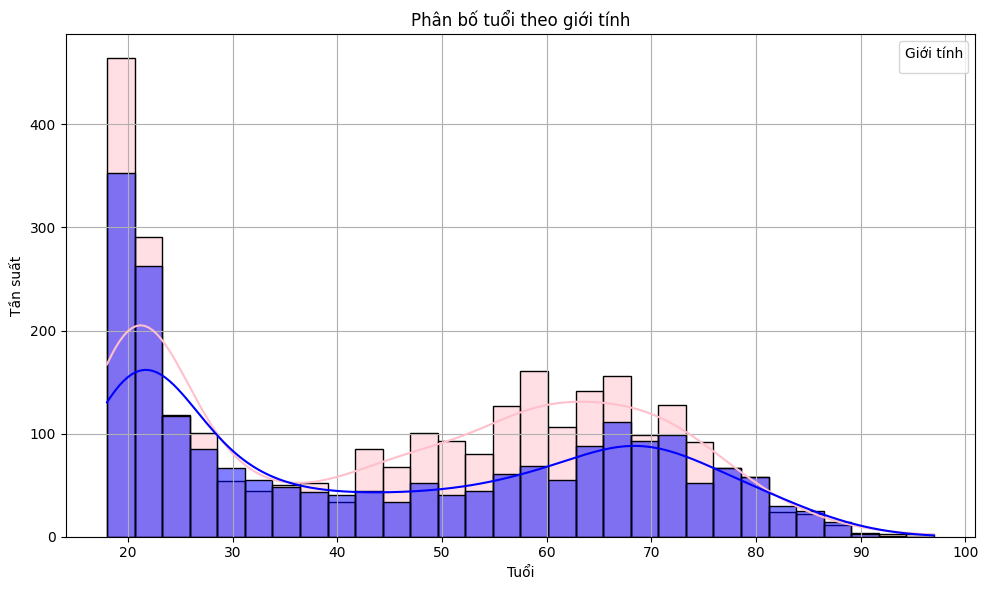

In [9]:
label_ls['subject_age'] = pd.to_numeric(label_ls['subject_age'], errors='coerce')
label_ls = label_ls.dropna(subset=['subject_age'])

plt.figure(figsize=(10, 6))

sns.histplot(data=label_ls, x="subject_age", hue="subject_sex", bins=30, kde=True,
             palette={"m": "blue", "f": "pink"}, edgecolor="black", discrete=False)

plt.title('Phân bố tuổi theo giới tính')
plt.xlabel('Tuổi')
plt.ylabel('Tần suất')
plt.legend(title='Giới tính')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
label_ls['subject_sex'].value_counts()

subject_sex
f    2837
m    2111
Name: count, dtype: int64

In [11]:
from scipy.ndimage import zoom, binary_erosion
from scipy.stats import ttest_ind
from nilearn import plotting
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
import deepbrain.extractor
deepbrain.extractor.tf = tf.compat.v1
from deepbrain import Extractor

ext = Extractor()


def load_subject_image(subject_id):
    if subject_id == "sub-BrainAge005600":
        return None
    nii_path = Path(f'{data_dir}/{subject_id}/anat/{subject_id}_T1w.nii/{subject_id}_T1w.nii')
    if nii_path.exists():
        return nib.load(str(nii_path)).get_fdata()
    print(nii_path)
    return None

def extract_brain(image):
    prob = ext.run(image)
    brain_mask = prob > 0.5
    eroded_mask = binary_erosion(brain_mask, iterations=2)
    return image * eroded_mask

def resize_image(img, target_shape=(128, 128, 128)):
    zoom_factors = [t / s for t, s in zip(target_shape, img.shape)]
    return zoom(img, zoom=zoom_factors, order=1)

def process_group(df, target_shape):
    imgs = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img = load_subject_image(row['subject_id'])
        if img is None:
            continue
        brain_img = extract_brain(img)
        resized_img = resize_image(brain_img, target_shape)
        imgs.append(resized_img)
    return np.array(imgs)

2025-05-25 14:03:44.070277: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [18]:
num_sample = 20
male = label_ls[(label_ls['subject_sex'].str.lower().str.strip() == 'm') & 
                (label_ls['subject_age'].between(45, 47))].head(num_sample)
female = label_ls[(label_ls['subject_sex'].str.lower().str.strip() == 'f') & 
                  (label_ls['subject_age'].between(45, 47))].head(num_sample)

target_shape = (128, 128, 128)
male_imgs = process_group(male, target_shape)
female_imgs = process_group(female, target_shape)
print(f"Loaded {len(male_imgs)} male and {len(female_imgs)} female images")

t_stat, _ = ttest_ind(female_imgs, male_imgs, axis=0, equal_var=False)
# male_mean = np.mean(np.stack(male_imgs), axis=0)
# female_mean = np.mean(np.stack(female_imgs), axis=0)
# diff_map = female_mean - male_mean  # voxel-wise difference

# Hiển thị ảnh t-map threshold theo p-value
sample_affine = nib.load('/kaggle/input/mri-dataset/not_skull_stripped/sub-BrainAge000000/anat/sub-BrainAge000000_T1w.nii/sub-BrainAge000000_T1w.nii').affine
t_map_img = nib.Nifti1Image(t_stat, affine=sample_affine)

100%|██████████| 20/20 [01:01<00:00,  3.06s/it]


Loaded 20 male and 20 female images


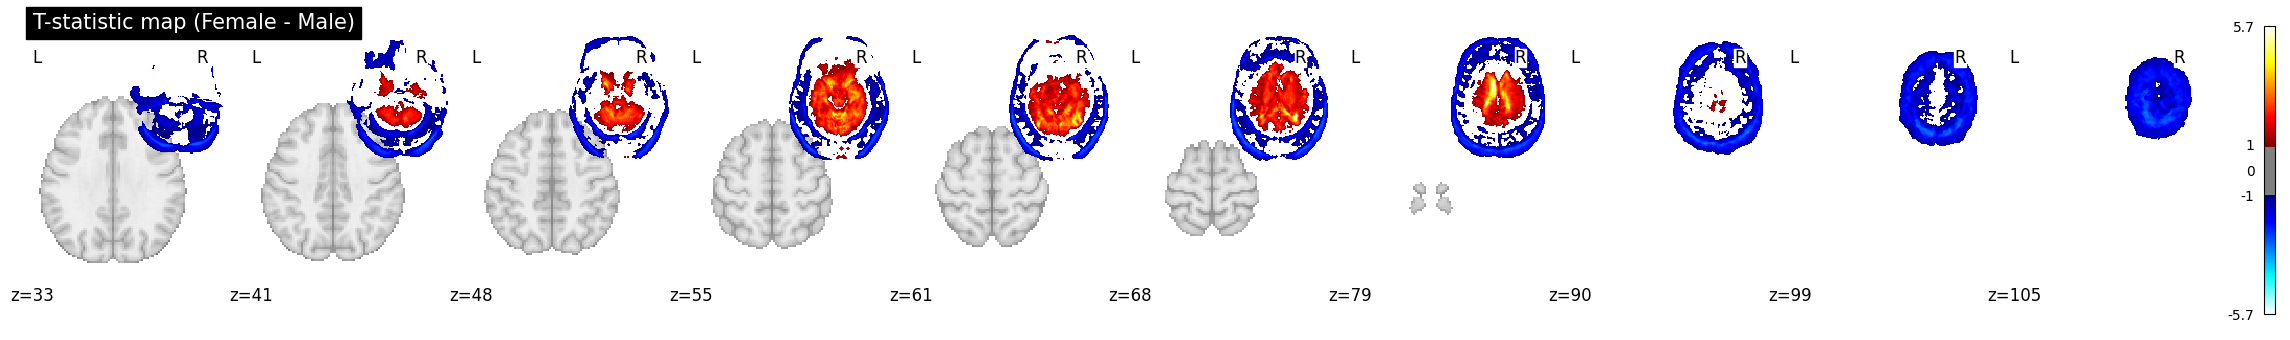

In [14]:
plotting.plot_stat_map(
    t_map_img,
    title="T-statistic map (Female - Male)",
    display_mode="z",
    cut_coords=10,
    cmap="cold_hot",
    threshold=1
)
plotting.show()

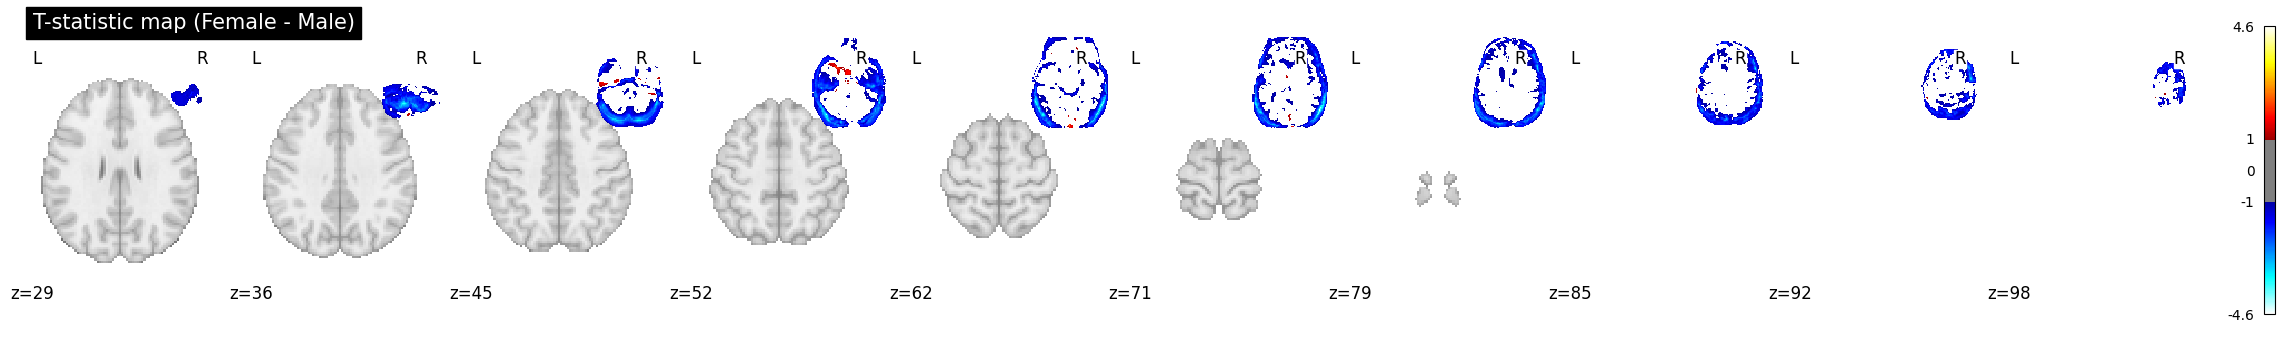

In [19]:
plotting.plot_stat_map(
    t_map_img,
    title="T-statistic map (Female - Male)",
    display_mode="z",
    cut_coords=10,
    cmap="cold_hot",
    threshold=1
)
plotting.show()

/usr/local/lib/python3.11/dist-packages/nilearn/plotting/img_plotting.py:1416: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


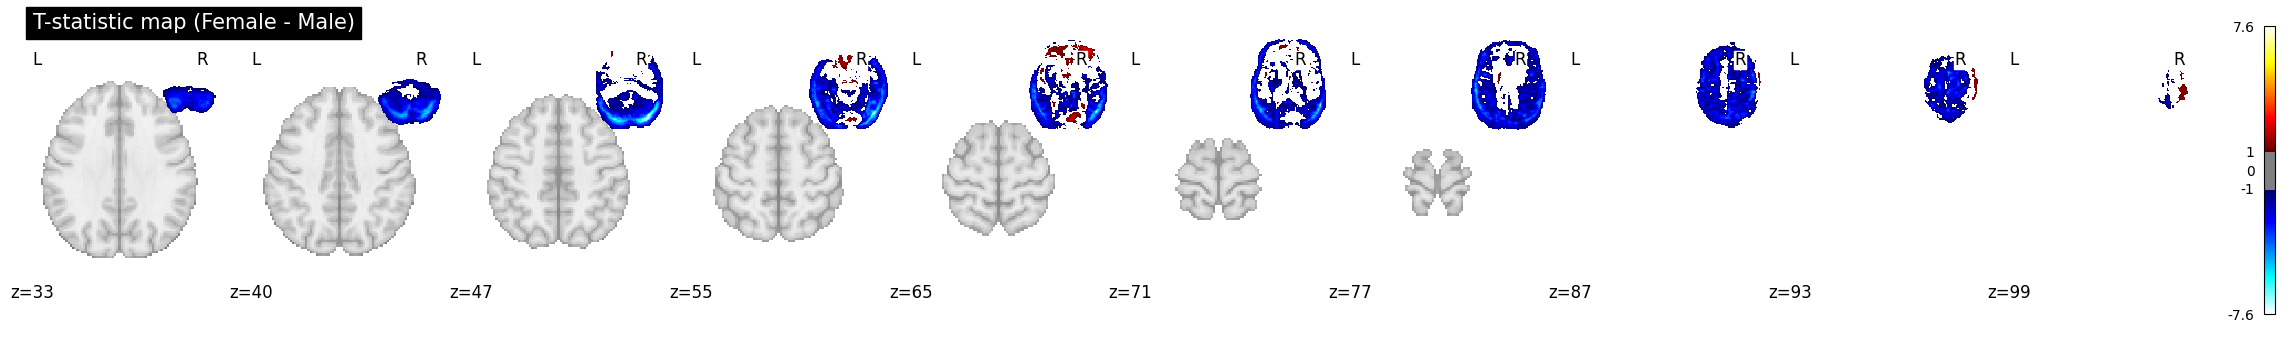

In [17]:
plotting.plot_stat_map(
    t_map_img,
    title="T-statistic map (Female - Male)",
    display_mode="z",
    cut_coords=10,
    cmap="cold_hot",
    threshold=1
)
plotting.show()

In [57]:
def show_csf_segmentation(image, csf_mask, slice_idx=None):
    if slice_idx is None:
        slice_idx = image.shape[2] // 2  # chọn lát giữa

    img_slice = image[:, :, slice_idx]
    mask_slice = csf_mask[:, :, slice_idx]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_slice.T, cmap='gray', origin='lower')
    plt.title('Ảnh MRI gốc')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_slice.T, cmap='Reds', origin='lower')
    plt.title('CSF Mask (threshold-based)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img_slice.T, cmap='gray', origin='lower')
    plt.imshow(mask_slice.T, cmap='Reds', alpha=0.4, origin='lower')
    plt.title('Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

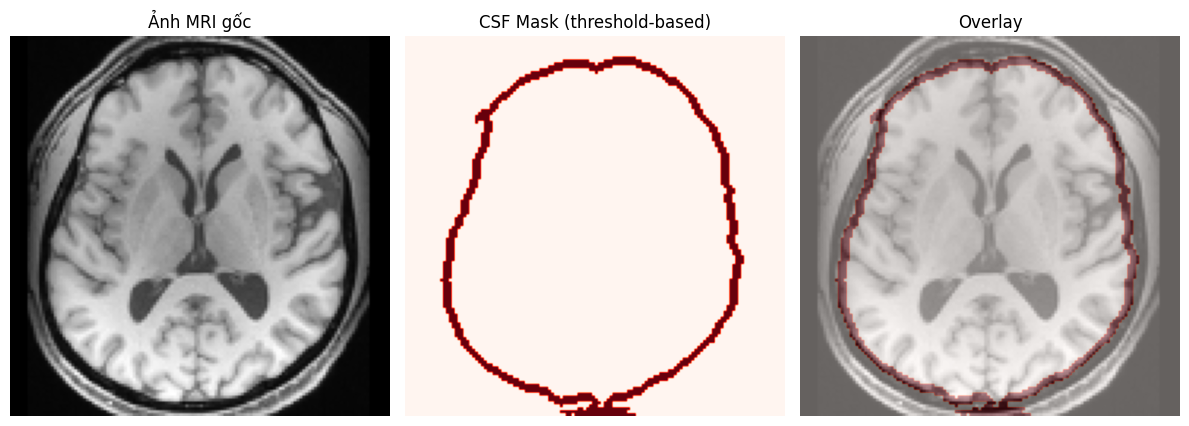

In [61]:
from scipy.ndimage import binary_erosion
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Monkey patch để deepbrain dùng TF1
import deepbrain.extractor
deepbrain.extractor.tf = tf.compat.v1  # Thay tf bằng tf.compat.v1

from deepbrain import Extractor
ext = Extractor()


def extract_csf_mask(image):
    prob = ext.run(image)
    brain_mask = prob > 0.5
    eroded = binary_erosion(brain_mask, iterations=3)
    csf_mask = brain_mask ^ eroded
    return csf_mask

test_img = load_subject_image('sub-BrainAge000000')

csf_mask = extract_csf_mask(test_img)

show_csf_segmentation(test_img, csf_mask)

In [9]:
subject_metadata = label_ls[['subject_sex','subject_id','dataset_name','subject_age']]
subject_metadata

,subject_sex,subject_id,dataset_name,subject_age
19,m,sub-BrainAge000019,ABIDE/Caltech,44.2
20,m,sub-BrainAge000020,ABIDE/Caltech,39.3
21,m,sub-BrainAge000021,ABIDE/Caltech,42.5
22,m,sub-BrainAge000022,ABIDE/Caltech,19.7
23,f,sub-BrainAge000023,ABIDE/Caltech,20
...,...,...,...,...
23209,f,sub-BrainAge023209,RocklandSample,66
23210,m,sub-BrainAge023210,RocklandSample,69
23211,m,sub-BrainAge023211,RocklandSample,23
23212,f,sub-BrainAge023212,RocklandSample,54


In [10]:
subject_metadata_dict = label_ls.set_index('subject_id')[['subject_sex','dataset_name','subject_age']].to_dict(orient='index')
len(subject_metadata_dict)

4948

In [23]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None, im_filenames=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        if im_filenames is not None:
            self.im_filenames = im_filenames
        else:
            self.im_filenames = self._gather_valid_paths()

    def _gather_valid_paths(self):
        paths = self.im_dir.glob("*/*/*/*.nii")
        valid_paths = []
        fail_paths = {
            self.im_dir / "sub-BrainAge005600/anat/sub-BrainAge005600_T1w.nii/sub-BrainAge005600_T1w.nii"
        }

        for path in paths:
            if not path.is_file():
                continue
                
            if path in fail_paths:
                continue
                
            subject_id = self._extract_subject_id(path)
            if subject_id not in self.label_ls:
                continue
            try:
                # nib.load(path).get_fdata()
                nib.load(path)
                valid_paths.append(path)
            except Exception:
                continue
        return valid_paths

    def _extract_subject_id(self, path):
        for part in Path(path).parts:
            if part.startswith("sub-BrainAge"):
                return part  # ví dụ: "sub-BrainAge000000"
        return None

    def _normalize(self, im):
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)
        return im.astype(np.float32)

    def _get_label(self, subject_id):
        sex = self.label_ls.get(subject_id, {}).get("subject_sex")
        if sex == 'm':
            return 0
        elif sex == 'f':
            return 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")
            
    def _get_age(self, subject_id):
        return self.label_ls.get(subject_id, {}).get("subject_age")
    
    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        subject_id = self._extract_subject_id(im_path)

        im = nib.load(im_path).get_fdata()
        im = self._normalize(im)

        label = self._get_label(subject_id)
        image = torch.from_numpy(im).unsqueeze(0)  # Shape: (1, H, W, D)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [11]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None, im_filenames=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        if im_filenames is not None:
            self.im_filenames = im_filenames
        else:
            self.im_filenames = self._gather_valid_paths()

    def _gather_valid_paths(self):
        paths = self.im_dir.glob("*/*/*/*.nii")
        valid_paths = []
        fail_paths = {
            self.im_dir / "sub-BrainAge005600/anat/sub-BrainAge005600_T1w.nii/sub-BrainAge005600_T1w.nii"
        }

        for path in paths:
            if not path.is_file():
                continue
                
            if path in fail_paths:
                continue
                
            subject_id = self._extract_subject_id(path)
            if subject_id not in self.label_ls:
                continue
            try:
                # nib.load(path).get_fdata()
                nib.load(path)
                valid_paths.append(path)
            except Exception:
                continue
        return valid_paths

    def _extract_subject_id(self, path):
        for part in Path(path).parts:
            if part.startswith("sub-BrainAge"):
                return part  # ví dụ: "sub-BrainAge000000"
        return None

    def _normalize(self, im):
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)
        return im.astype(np.float32)

    def _get_label(self, subject_id):
        sex = self.label_ls.get(subject_id, {}).get("subject_sex")
        if sex == 'm':
            return 0
        elif sex == 'f':
            return 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")
            
    def _get_age(self, subject_id):
        return self.label_ls.get(subject_id, {}).get("subject_age")
    
    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        subject_id = self._extract_subject_id(im_path)

        im = nib.load(im_path).get_fdata()
        im = self._normalize(im)

        mid_slice = im.shape[2] // 2
        im_slice = im[:, :, mid_slice]
        
        image_2d = np.stack([im_slice]*3, axis=0)
        image_tensor = torch.from_numpy(image_2d).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        label = self._get_label(subject_id)
        return image_tensor, torch.tensor(label, dtype=torch.float32)

In [12]:
def create_global_bin_pool(data: MRIDataset) -> dict:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array([
        subject_metadata.get(sid, {}).get("subject_age", np.nan)
        for sid in subject_ids
    ], dtype=np.float32)

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)

    global_bin_pool = {}
    for bin_id in np.unique(age_bins):
        bin_indices = valid_indices[age_bins == bin_id]
        global_bin_pool[bin_id] = set(bin_indices.tolist())

    return global_bin_pool


def get_sample_data(
    data: MRIDataset,
    overlap: float,
    partition_id: int,
    num_partitions: int,
    global_bin_pool: dict,
    num_samples: int = None,
) -> list:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array(
        [subject_metadata.get(sid, {}).get("subject_age", np.nan) for sid in subject_ids],
        dtype=np.float32
    )

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)
    total_samples = len(valid_indices)
    client_sample_count = total_samples // num_partitions

    rng = np.random.default_rng(seed=partition_id + 42)
    sampled_indices = set()
    used_bins = set()

    all_bins = list(global_bin_pool.keys())
    rng.shuffle(all_bins)
    target_num_bins = max(1, int(overlap * len(all_bins)))

    # Vòng lặp đến khi đủ sample
    while len(sampled_indices) < client_sample_count:
        # Chọn bin chưa dùng
        candidate_bins = [b for b in all_bins if b not in used_bins]
        if not candidate_bins:
            break  # Không còn bin nào để lấy

        selected_bins = candidate_bins[:target_num_bins]
        used_bins.update(selected_bins)

        # Lấy toàn bộ samples từ các bin đã chọn
        combined_indices = []
        for bin_id in selected_bins:
            available = global_bin_pool[bin_id]
            combined_indices.extend(list(available))

        rng.shuffle(combined_indices)

        # Chọn mẫu đến khi đủ
        needed = client_sample_count - len(sampled_indices)
        to_take = combined_indices[:needed]
        sampled_indices.update(to_take)

        # Xoá mẫu đã chọn khỏi global_bin_pool
        for idx in to_take:
            for bin_id in selected_bins:
                global_bin_pool[bin_id].discard(idx)

    if num_samples and num_samples > client_sample_count:
        remaining_needed = num_samples - client_sample_count
        remaining_pool = list(set(valid_indices) - sampled_indices)
        rng.shuffle(remaining_pool)
        extra = remaining_pool[:remaining_needed]
        sampled_indices.update(extra)

    return list(sampled_indices)

In [13]:
def load_client_datasets(partition_id: int, num_partitions: int, dataset, overlap: int, global_bin_pool: dict, num_samples=None):
    data = dataset
    sampled_indices = get_sample_data(data=data, overlap=overlap, partition_id=partition_id, num_partitions=num_partitions, 
                                      global_bin_pool=global_bin_pool, num_samples=num_samples)

    np.random.shuffle(sampled_indices)
    train_size = int(0.8 * len(sampled_indices))
    train_indices = sampled_indices[:train_size]
    val_indices = sampled_indices[train_size:]

    train_subset = Subset(data, train_indices)
    val_subset = Subset(data, val_indices)
    return train_subset, val_subset

In [14]:
def load_server_test_datasets(data: MRIDataset):
    testloader = DataLoader(data, batch_size=BATCHSIZE, shuffle=False)
    return testloader

In [15]:
dataset = MRIDataset(data_dir, subject_metadata_dict, im_filenames=im_filenames)
len(dataset)

4948

In [ ]:
# def save_filenames(im_filenames, output_path):
#     output_path = Path(output_path)
#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     with open(output_path, 'w') as f:
#         json.dump([str(path) for path in im_filenames], f)
#     print(output_path)

In [ ]:
# save_filenames(dataset.im_filenames, "valid_filenames.json")

In [16]:
from sklearn.model_selection import train_test_split

all_filenames = dataset.im_filenames

# Chia train/test 
train_filenames, test_filenames = train_test_split(
    all_filenames, test_size=0.2, random_state=42, shuffle=True
)

trainset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=train_filenames
)

testset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=test_filenames
)


In [17]:
global_bin_pool = create_global_bin_pool(trainset)

In [ ]:
train_subset, _ = load_client_datasets(partition_id=5, num_partitions=10, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
print(len(train_subset))

dataloader = DataLoader(train_subset, batch_size=2)
images, labels = dataloader
images = images.numpy()
slice_idx = images.shape[3] // 2
slices = images[:, :, :, slice_idx]

class_names = ["Male", "Female"]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, ax in enumerate(axs.flat):
    if i < len(slices):
        ax.imshow(slices[i], cmap='gray')
        ax.set_title(class_names[labels.item()])
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

316


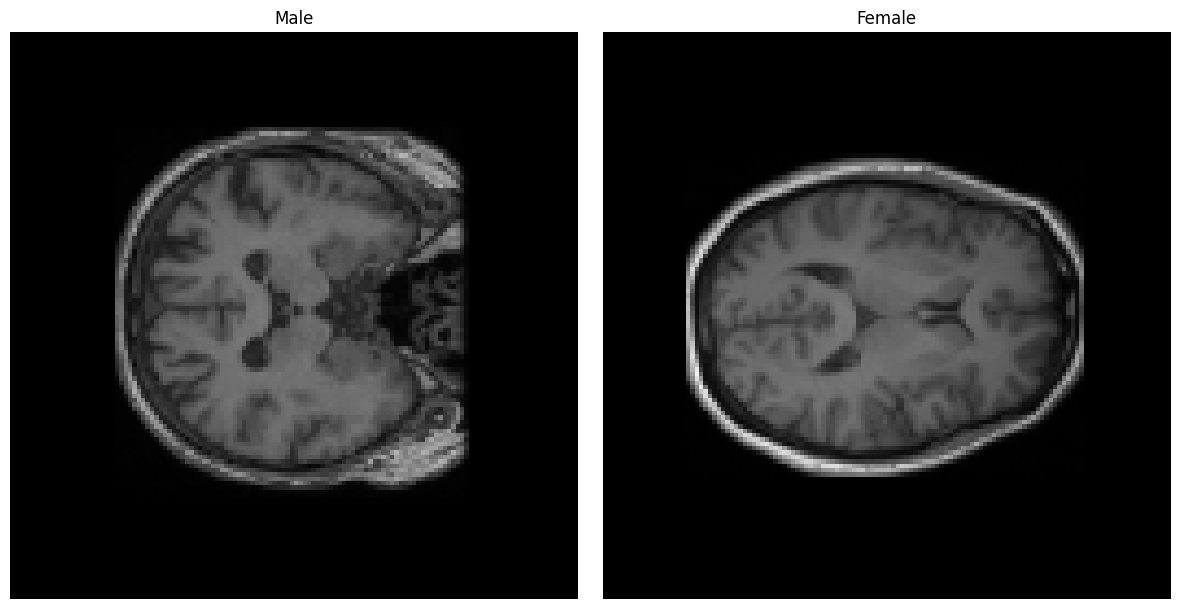

In [25]:
train_subset, _ = load_client_datasets(partition_id=5, num_partitions=10, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
print(len(train_subset))

dataloader = DataLoader(train_subset, batch_size=2)
images, labels = next(iter(dataloader))  # (B, 3, H, W)

images = images.numpy()
labels = labels.numpy()
class_names = ["Male", "Female"]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, ax in enumerate(axs.flat):
    img = np.transpose(images[i], (1, 2, 0))  # (3, H, W) → (H, W, 3)
    ax.imshow(img)
    ax.set_title(class_names[int(labels[i])])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [26]:
def plot_age_distribution(subset):
    dataset = subset.dataset
    indices = subset.indices

    data = []
    for i in indices:
        subject_id = dataset._extract_subject_id(dataset.im_filenames[i])
        metadata = dataset.label_ls.get(subject_id, {})
        age = metadata.get("subject_age")
        sex = metadata.get("subject_sex")
        if age is not None and not pd.isna(age) and sex in ['m', 'f']:
            data.append({"age": age, "sex": sex })

    if not data:
        print("No valid age/sex data found.")
        return

    df = pd.DataFrame(data)

    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x="age", hue="sex", bins=30, kde=True, palette={"m": "blue", "f": "pink"}, edgecolor="black")
    plt.title("Age Distribution by Sex")
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

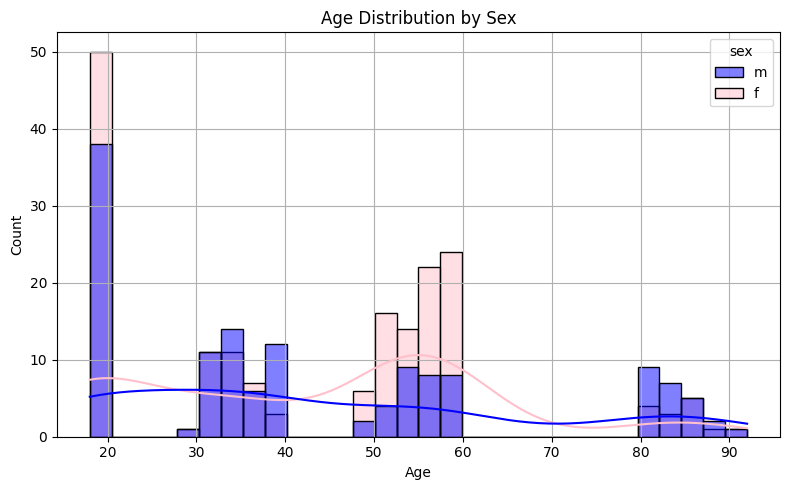

In [27]:
plot_age_distribution(train_subset)

In [ ]:
plot_age_distribution(train_subset)

In [53]:
def analyze_sex_difference(subset, num_sample=30, threshold=1):
    dataset = subset.dataset
    indices = subset.indices

    # Lấy ra subject_id, tuổi và giới tính
    metadata = []
    for i in indices:
        im_path = dataset.im_filenames[i]
        sid = dataset._extract_subject_id(im_path)
        label = dataset.label_ls.get(sid, {})
        age = label.get("subject_age")
        sex = label.get("subject_sex")
        if sex in ['m', 'f'] and age is not None and not pd.isna(age):
            metadata.append({"idx": i, "subject_id": sid, "age": age, "sex": sex.lower().strip()})

    df = pd.DataFrame(metadata)

    # Chọn các mẫu không lọc tuổi
    male_ids = df[df["sex"] == 'm'].sample(n=num_sample, random_state=42)
    female_ids = df[df["sex"] == 'f'].sample(n=num_sample, random_state=42)

    print(f"Loading images: {len(male_ids)} male, {len(female_ids)} female")

    # Sử dụng process_group 
    target_shape=(128, 128, 128)
    male_imgs = process_group(male_ids, target_shape)
    female_imgs = process_group(female_ids, target_shape)

    # Thống kê voxel-wise
    t_stat, _ = ttest_ind(female_imgs, male_imgs, axis=0, equal_var=False)

    # Load affine từ một mẫu bất kỳ
    sample_path = dataset.im_filenames[indices[0]]
    sample_affine = nib.load(sample_path).affine
    t_map_img = nib.Nifti1Image(t_stat, affine=sample_affine)

    # Hiển thị t-map
    print("Displaying T-statistic map (Female - Male)...")
    plotting.plot_stat_map(
        t_map_img,
        title="T-statistic map (Female - Male)",
        display_mode="z",
        cut_coords=10,
        cmap="cold_hot",
        threshold=threshold
    )
    plotting.show()

Loading images: 30 male, 30 female


100%|██████████| 30/30 [01:31<00:00,  3.04s/it]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2215: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Displaying T-statistic map (Female - Male)...


/usr/local/lib/python3.11/dist-packages/nilearn/plotting/img_plotting.py:1416: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


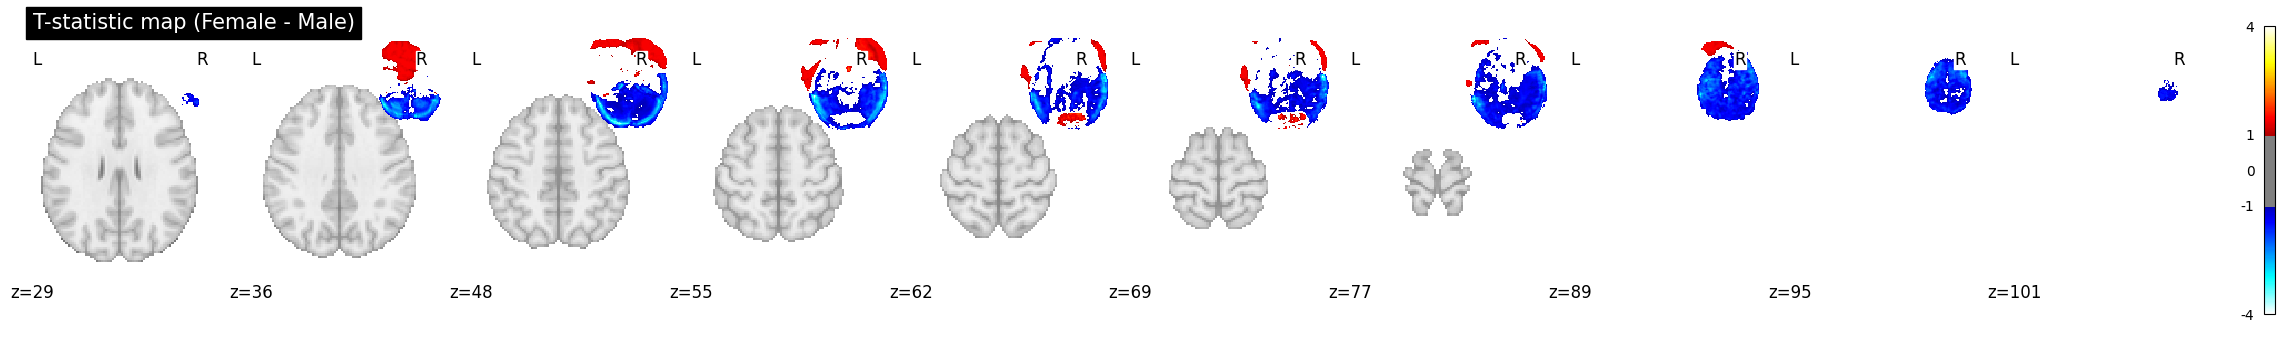

In [54]:
analyze_sex_difference(train_subset)

Loading images: 30 male, 30 female


100%|██████████| 30/30 [01:31<00:00,  3.04s/it]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2215: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Displaying T-statistic map (Female - Male)...


/usr/local/lib/python3.11/dist-packages/nilearn/plotting/img_plotting.py:1416: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


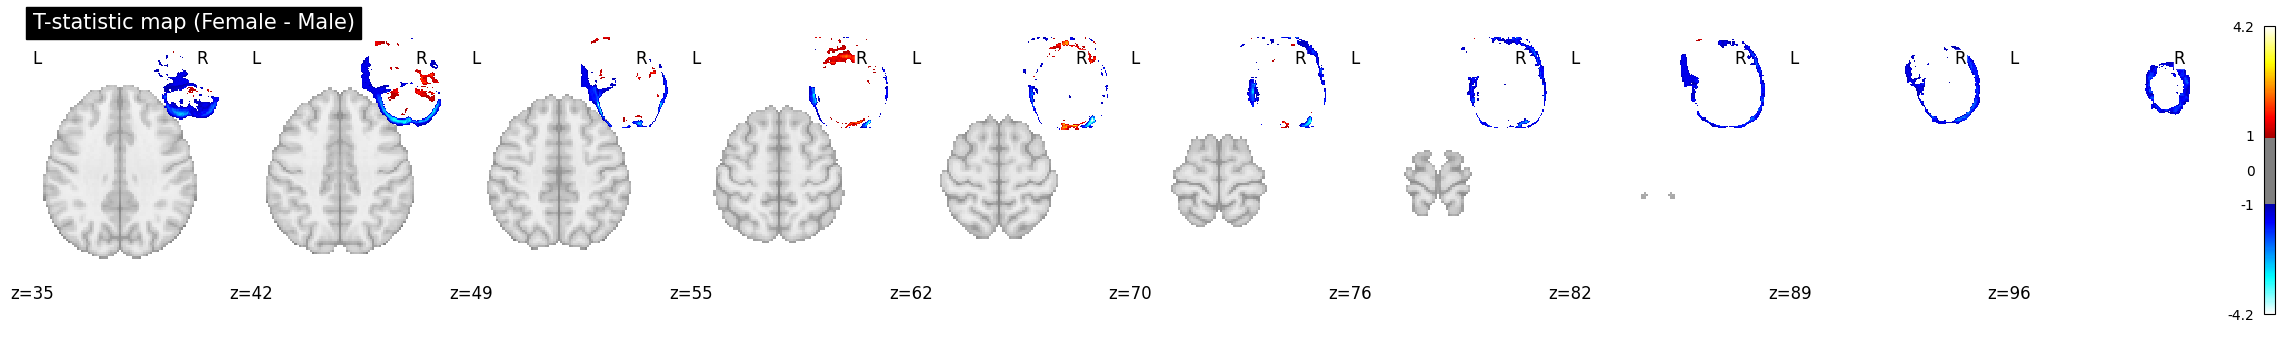

In [57]:
analyze_sex_difference(train_subset)

In [37]:
def visualize_age_client_distribution(dataset, num_partitions=10, num_samples=None, overlap=0.6, global_bin_pool=None):
    # dữ liệu gốc
    subject_metadata = dataset.label_ls
    subject_ids = [dataset._extract_subject_id(path) for path in dataset.im_filenames]

    age_array = np.array(
        [subject_metadata.get(sid, {}).get("subject_age", np.nan) for sid in subject_ids],
        dtype=np.float32
    )

    valid_mask = ~np.isnan(age_array)
    age_array = age_array[valid_mask]

    # Thêm cột phân biệt nguồn gốc
    original_df = pd.DataFrame({
        "age": age_array,
        "partition": "Original"
    })
    
    all_dfs = []

    for i in range(num_partitions):
        subset, _ = load_client_datasets(
            partition_id=i, 
            num_partitions=num_partitions, 
            dataset=dataset, 
            num_samples=num_samples,
            overlap=overlap,
            global_bin_pool=global_bin_pool
        )
        subset_data = []

        for idx in subset.indices:
            subject_id = subset.dataset._extract_subject_id(subset.dataset.im_filenames[idx])
            metadata = subset.dataset.label_ls.get(subject_id, {})
            age = metadata.get("subject_age")

            if age is not None and not pd.isna(age):
                subset_data.append({"age": age, "partition": f"Client {i}"})

        if subset_data:
            df = pd.DataFrame(subset_data)
            all_dfs.append(df)

    combined_df = pd.concat(all_dfs, ignore_index=True)
    compare_df = pd.concat([original_df, combined_df], ignore_index=True)

    print(f'Số mẫu dữ liệu:{len(combined_df)}')

    original_total = len(original_df)

    plt.figure(figsize=(12, 7))
    
    for partition in compare_df["partition"].unique():
        sub_df = compare_df[compare_df["partition"] == partition]
        weights = np.ones(len(sub_df)) / original_total
        sns.kdeplot(
            x=sub_df["age"],
            label=partition,
            linewidth=2.5 if partition == "Original" else 1.2,
            fill=(partition == "Original"),
            alpha=0.3 if partition == "Original" else 0.4,
            common_norm=False,
        )

    plt.title(f"Age Distributions Across Client (Overlap = {overlap})")
    plt.xlabel("Age")
    plt.ylabel("Density")
    plt.legend(title="Data Source")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("age_distributions.png")
    plt.show()

In [36]:
def visualize_labels_client_distribution(dataset, num_partitions=10, num_samples=None, overlap=0.6, global_bin_pool=None):
    client_gender_count = {}  # Dùng để đếm số lượng nam/nữ trong từng client

    for i in range(num_partitions):
        subset, _ = load_client_datasets(
            partition_id=i,
            num_partitions=num_partitions,
            dataset=dataset,
            num_samples=num_samples,
            overlap=overlap,
            global_bin_pool=global_bin_pool
        )

        male_count = 0
        female_count = 0

        for idx in subset.indices:
            subject_id = subset.dataset._extract_subject_id(subset.dataset.im_filenames[idx])
            metadata = subset.dataset.label_ls.get(subject_id, {})
            sex = metadata.get("subject_sex")

            if sex == 'm':
                male_count += 1
            elif sex == 'f':
                female_count += 1

        client_gender_count[f"Client {i}"] = {"Male": male_count, "Female": female_count}

    # Chuẩn bị dữ liệu để vẽ biểu đồ
    clients = list(client_gender_count.keys())
    male_counts = [client_gender_count[client]["Male"] for client in clients]
    female_counts = [client_gender_count[client]["Female"] for client in clients]

    x = range(len(clients))
    bar_width = 0.35

    # Vẽ biểu đồ
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.bar(x, male_counts, width=bar_width, label="Nam", color='blue')
    ax.bar([p + bar_width for p in x], female_counts, width=bar_width, label="Nữ", color='pink')

    ax.set_xlabel('Client')
    ax.set_ylabel('Number')
    ax.set_title(f'Gender Label Distribution per Client (Overlap = {overlap})')
    ax.set_xticks([p + bar_width / 2 for p in x])
    ax.set_xticklabels(clients)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("sex_distributions.png")
    plt.show()

In [38]:
def show_interact(overlap):
    global_bin_pool = create_global_bin_pool(trainset)
    visualize_age_client_distribution(trainset, num_partitions=10, overlap=overlap, global_bin_pool=global_bin_pool)
    global_bin_pool = create_global_bin_pool(trainset)
    visualize_labels_client_distribution(trainset, num_partitions=10, overlap=overlap, global_bin_pool=global_bin_pool)

interact(show_interact, overlap=(0.0, 1.0, 0.05));

interactive(children=(FloatSlider(value=0.5, description='overlap', max=1.0, step=0.05), Output()), _dom_class…

## Model

### 3D

In [26]:
class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module(
            'conv1',
            nn.Conv3d(num_input_features,
                      bn_size * growth_rate,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module(
            'conv2',
            nn.Conv3d(bn_size * growth_rate,
                      growth_rate,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super().forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features,
                                     p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate,
                                growth_rate, bn_size, drop_rate)
            self.add_module('denselayer{}'.format(i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module(
            'conv',
            nn.Conv3d(num_input_features,
                      num_output_features,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))

class DenseNet(nn.Module):
    def __init__(self,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 growth_rate=32,
                 block_config=(6, 12, 24, 16),
                 num_init_features=64,
                 bn_size=4,
                 drop_rate=0,
                 num_classes=1):
        super().__init__()

        # First convolution
        self.features = [('conv1',
                          nn.Conv3d(n_input_channels,
                                    num_init_features,
                                    kernel_size=(conv1_t_size, 7, 7),
                                    stride=(conv1_t_stride, 2, 2),
                                    padding=(conv1_t_size // 2, 3, 3),
                                    bias=False)),
                         ('norm1', nn.BatchNorm3d(num_init_features)),
                         ('relu1', nn.ReLU(inplace=True))]
        if not no_max_pool:
            self.features.append(
                ('pool1', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)))
        self.features = nn.Sequential(OrderedDict(self.features))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers,
                                num_input_features=num_features,
                                bn_size=bn_size,
                                growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock{}'.format(i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition{}'.format(i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Khởi tạo trọng số
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool3d(out, output_size=(1, 1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

### 2D

In [18]:
class BrainMRINet(nn.Module):
    def __init__(self, num_classes: int = 1):
        super(BrainMRINet, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1, 1))  # Output: (128, 1, 1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # Use `1` for binary, `n` for multi-class
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x


In [19]:
# Hàm hỗ trợ cho mô hình

# Lấy tham số mô hình
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

# Cập nhật tham số mô hình
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def save_model_parameters(parameters, file_path: str = "final_model.pth"):
    if parameters is None:
        print("No parameters available to save.")
        return
    net = model.to(DEVICE)
    final_ndarrays = parameters_to_ndarrays(parameters)
    set_parameters(net, final_ndarrays)
    torch.save(net.state_dict(), file_path)
    print(f"Model parameters saved to {file_path}")


def train(net, trainloader, epochs: int, lr: float, id: int) -> Tuple[float, float]:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
    net.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(trainloader, desc=f"[Client {id} Epoch {epoch+1}/{epochs}]", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE).float()
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            
            progress_bar.set_postfix(loss=loss.item())
        
        avg_epoch_loss = epoch_loss / len(trainloader.dataset)
        print(f"[Client {id}] Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f}")
        total_loss += epoch_loss
    
    avg_loss = total_loss / (len(trainloader.dataset) * epochs)
    accuracy = correct / total if total > 0 else 0.0
    print(f"[Client {id}] Train Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

def test(net, testloader, id: int, server_test=False) -> Tuple[float, float]:
    criterion = nn.BCEWithLogitsLoss()
    net.eval()
    loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(testloader, desc=f"[Client {id}] Testing", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE).float()
            outputs = net(images)
            loss += criterion(outputs, labels.unsqueeze(1)).item() * labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            progress_bar.set_postfix(loss=loss/total)
    
    avg_loss = loss / len(testloader.dataset) if len(testloader.dataset) > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    if server_test:
        print(f"[Server Test] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    else:
        print(f"[Client {id}] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

In [28]:
model = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12))

In [20]:
model = BrainMRINet()

In [25]:
# continue train
# model.load_state_dict(torch.load("/kaggle/input/fl-3d-dense-net/pytorch/default/1/final_model.pth"))

<All keys matched successfully>

In [ ]:
# trainloader = DataLoader(train_subset, batch_size=2)
# train(model,trainloader,1,0.001,1)

In [21]:
from torchinfo import summary

summary(model, input_size=(1, 3, 130, 130))

Layer (type:depth-idx)                   Output Shape              Param #
BrainMRINet                              [1, 1]                    --
├─Sequential: 1-1                        [1, 128, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 16, 130, 130]         448
│    └─BatchNorm2d: 2-2                  [1, 16, 130, 130]         32
│    └─ReLU: 2-3                         [1, 16, 130, 130]         --
│    └─MaxPool2d: 2-4                    [1, 16, 65, 65]           --
│    └─Conv2d: 2-5                       [1, 32, 65, 65]           4,640
│    └─BatchNorm2d: 2-6                  [1, 32, 65, 65]           64
│    └─ReLU: 2-7                         [1, 32, 65, 65]           --
│    └─MaxPool2d: 2-8                    [1, 32, 32, 32]           --
│    └─Conv2d: 2-9                       [1, 64, 32, 32]           18,496
│    └─BatchNorm2d: 2-10                 [1, 64, 32, 32]           128
│    └─ReLU: 2-11                        [1, 64, 32, 32]           --
│    └

## Client

In [22]:
# Định nghĩa Client
class FlowerClient(Client):
    def __init__(self, partition_id, net, trainloader, valloader, num_partitions):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.num_partitions = num_partitions
        self.previous_parameters = None

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.partition_id}] get_parameters")
        ndarrays = get_parameters(self.net)
        parameters = ndarrays_to_parameters(ndarrays)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(status=status, parameters=parameters)

    def is_dropout(self, round_num: int) -> bool:
        seed = 42 + self.partition_id + round_num
        random.seed(seed)
        return random.random() < DROPOUT

    def fit(self, ins: FitIns) -> FitRes:
        round_num = ins.config.get('server_round')
        if self.is_dropout(round_num):
            print(f"[Client {self.partition_id}] dropped out in round {ins.config.get('server_round')}")
            status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
            return FitRes(
                status=status,
                parameters=ins.parameters,
                num_examples=0,
                metrics={}
            )
        print(f"[Client {self.partition_id}] fit, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        lr = ins.config.get("lr", 0.001)
        epochs = ins.config.get("epochs", 1)
        train_loss, train_accuracy = train(self.net, self.trainloader, epochs=epochs, lr=lr, id=self.partition_id)

        ndarrays_updated = get_parameters(self.net)
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)
        self.previous_parameters = parameters_updated

        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader.dataset),
            metrics={
                "train_loss": float(train_loss),
                "train_accuracy": float(train_accuracy)
            }
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        round_num = ins.config.get('server_round')
        if self.is_dropout(round_num):
            print(f"[Client {self.partition_id}] dropped out in evaluation round {ins.config.get('server_round')}")
            status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
            return EvaluateRes(
                status=status,
                loss=0.0,
                num_examples=0,
                metrics={}
            )

        print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        val_loss, val_accuracy = test(self.net, self.valloader, self.partition_id)
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(val_loss),
            num_examples=len(self.valloader.dataset),
            metrics={"val_accuracy": float(val_accuracy)}
        )

# Hàm tạo client
def client_fn(context: Context) -> Client:
    net = model.to(DEVICE)
    partition_id = int(context.node_config["partition-id"])
    num_partitions = context.node_config["num-partitions"]
    
    train_subset, val_subset = load_client_datasets(partition_id, num_partitions, dataset=trainset, overlap=OVERLAP, global_bin_pool=global_bin_pool)
    trainloader = DataLoader(train_subset, batch_size=BATCHSIZE, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=BATCHSIZE, shuffle=False)
    
    return FlowerClient(partition_id, net, trainloader, valloader, num_partitions).to_client()

# Client
client = ClientApp(client_fn=client_fn)

## Strategy server

In [30]:
# Custom Strategy
class FedCustom(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 1,
        min_evaluate_clients: int = 1,
        min_available_clients: int = 1,
        evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]] = None
    ):
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn

    def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
        net = model
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

        standard_config = {"lr": LR,
                           "epochs": epochs_round,
                           "server_round": server_round}
        fit_configurations = []
        for client in clients:
            fit_configurations.append((client, FitIns(parameters, standard_config)))
        return fit_configurations

    def aggregate_gpu(self, results: List[Tuple[NDArrays, int]]) -> NDArrays:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        total = sum(n for _, n in results)
        torch_results = [
            ([torch.tensor(arr).to(device) for arr in weights], n)
            for weights, n in results
        ]
        weighted_sum = [
            sum(w[i] * n for w, n in torch_results) / total
            for i in range(len(torch_results[0][0]))
        ]
        return [w.cpu().numpy() for w in weighted_sum]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if not results:
            return None, {}

        valid_results = [(client_proxy, res) for client_proxy, res in results if res.status.code == Code.OK]
        if not valid_results:
            return None, {}

        weights_results = [
            (parameters_to_ndarrays(res.parameters), res.num_examples)
            for _, res in valid_results
        ]
        parameters_aggregated = ndarrays_to_parameters(
            # flwr.server.strategy.aggregate.aggregate(weights_results)
            self.aggregate_gpu(weights_results)
        )

        # save model
        if wandb_log:
            if server_round % 2 == 0:
                save_model_parameters(parameters_aggregated, file_path="final_model.pth")

        total_examples = sum(res.num_examples for _, res in valid_results)
        train_loss_agg = sum(
            res.num_examples * res.metrics["train_loss"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0
        train_accuracy_agg = sum(
            res.num_examples * res.metrics["train_accuracy"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "train_loss": train_loss_agg,
            "train_accuracy": train_accuracy_agg,
            "clients_participated": len(valid_results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "train_loss": train_loss_agg,
                "train_accuracy": train_accuracy_agg,
                "clients_participated_fit": len(valid_results)
            })

        HISTORY["train_loss"].append(train_loss_agg)
        HISTORY["train_accuracy"].append(train_accuracy_agg)
        HISTORY["clients_participated_fit"].append(len(valid_results))

        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        if self.fraction_evaluate == 0.0:
            return []
        config = {"server_round": server_round}
        evaluate_ins = EvaluateIns(parameters, config)
        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        if not results:
            print(f"Round {server_round}: No results received")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        valid_results = [
            (client_proxy, res) for client_proxy, res in results
            if res.status.code == Code.OK
        ]
        if not valid_results:
            print(f"Round {server_round}: No valid evaluation results")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        total_examples = sum(res.num_examples for _, res in valid_results)
        loss_aggregated = flwr.server.strategy.aggregate.weighted_loss_avg(
            [(res.num_examples, res.loss) for _, res in valid_results]
        )
        val_accuracy_aggregated = sum(
            res.num_examples * res.metrics["val_accuracy"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "val_loss": loss_aggregated,
            "val_accuracy": val_accuracy_aggregated,
            "clients_participated": len(valid_results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "val_loss": loss_aggregated,
                "val_accuracy": val_accuracy_aggregated,
                "clients_participated_eval": len(valid_results)
            })

        HISTORY["val_loss"].append(loss_aggregated)
        HISTORY["val_accuracy"].append(val_accuracy_aggregated)
        HISTORY["clients_participated_eval"].append(len(valid_results))

        return loss_aggregated, metrics_aggregated

    def evaluate(self, server_round: int, parameters: Parameters) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        if server_round == 0 or self.evaluate_fn is None:
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        return eval_res

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

# Hàm đánh giá trên server
def evaluate_fn(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = model.to(DEVICE)
    set_parameters(net, parameters)
    testloader = load_server_test_datasets(data=testset)
    test_loss, test_accuracy = test(net, testloader, id=-1, server_test=True)

    if wandb_log:
        wandb_logger.log({
            "round": server_round,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy
        })
    
    HISTORY["test_loss"].append(test_loss)
    HISTORY["test_accuracy"].append(test_accuracy)
    
    return test_loss, {"test_accuracy": test_accuracy}

# Server
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedCustom(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=1,
        min_evaluate_clients=1,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn
    )
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

## Training

In [41]:
wandb_log = False

In [24]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)
wandb_log = True

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nguyenxuanpk357 (nguyentuoc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [25]:
config={
    "num_client": NUM_CLIENTS,
    "num_rounds": NUM_ROUNDS,
    "dropout": DROPOUT,
    "learning_rate": LR,
    "architecture": "2DNet",
    "dataset": "Mri",
    "epochs_round": epochs_round,
    "overlap": OVERLAP,
}
print(config)

{'num_client': 10, 'num_rounds': 30, 'dropout': 0.1, 'learning_rate': 0.001, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}


In [26]:
wandb_logger = wandb.init(
    project="Federated-Learning",
    name=f"experiment_2_2D",
    config=config,
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
# Cấu hình backend
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0}}
if DEVICE.type == "cuda":
    backend_config["client_resources"]["num_gpus"] = 0.5

# Khởi tạo HISTORY
HISTORY = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
    "clients_participated_fit": [],
    "clients_participated_eval": []
}

# Chạy simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

wandb_logger.finish()

INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=1420) 2025-05-27 14:55:11.841168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1424) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1424) E0000 00:00:1748357711.866204    1424 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1420) E0000 00:00:1748357711.903905    1420 cuda_blas.cc:1418] Unable to register cuBLAS factory: A

(ClientAppActor pid=1420) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=1420) [Client 5] Epoch 1/1 - Loss: 0.4115
(ClientAppActor pid=1420) [Client 5] Train Loss: 0.4115 | Accuracy: 81.33%
(ClientAppActor pid=1422) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1} [repeated 3x across cluster]
(ClientAppActor pid=1420) [Client 6] dropped out in round 1
(ClientAppActor pid=1422) [Client 3] Epoch 1/1 - Loss: 0.4538 [repeated 3x across cluster]
(ClientAppActor pid=1422) [Client 3] Train Loss: 0.4538 | Accuracy: 79.75% [repeated 3x across cluster]
(ClientAppActor pid=1423) [Client 9] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1} [repeated 3x across cluster]
(ClientAppActor pid=1422) [Client 0] dropped out in round 1
(ClientAppActor pid=1420) [Client 7] Epoch 1/1 - Loss: 0.4134
(ClientAppActor pid=1420) [Client 7] Train Loss: 0.4134 | Accuracy: 82.59%
(ClientAppActor pid=1422) [Client 4] fit, config: {'lr': 0.001, '

INFO :      aggregate_fit: received 8 results and 2 failures


(ClientAppActor pid=1424) [Client 8] Epoch 1/1 - Loss: 0.4579
(ClientAppActor pid=1424) [Client 8] Train Loss: 0.4579 | Accuracy: 77.85%


INFO :      fit progress: (1, 1.2109482601435497, {'test_accuracy': 0.4393939393939394}, 159.52258254900016)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 1.2109 | Accuracy: 43.94%
(ClientAppActor pid=1420) [Client 4] evaluate, config: {'server_round': 1}
(ClientAppActor pid=1424) [Client 0] dropped out in evaluation round 1
(ClientAppActor pid=1420) [Client 4] Test Loss: 1.3066 | Accuracy: 39.24%
(ClientAppActor pid=1424) [Client 5] evaluate, config: {'server_round': 1} [repeated 3x across cluster]
(ClientAppActor pid=1420) [Client 6] dropped out in evaluation round 1
(ClientAppActor pid=1422) [Client 9] Test Loss: 1.3292 | Accuracy: 37.97% [repeated 4x across cluster]
(ClientAppActor pid=1424) [Client 3] evaluate, config: {'server_round': 1} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 8 results and 2 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1420) [Client 4] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=1422) [Client 5] dropped out in round 2
(ClientAppActor pid=1420) [Client 4] Epoch 1/1 - Loss: 0.3884
(ClientAppActor pid=1420) [Client 4] Train Loss: 0.3884 | Accuracy: 84.49%
(ClientAppActor pid=1424) [Client 3] Test Loss: 1.1824 | Accuracy: 45.57% [repeated 3x across cluster]
(ClientAppActor pid=1422) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2} [repeated 3x across cluster]
(ClientAppActor pid=1422) [Client 6] Epoch 1/1 - Loss: 0.4108 [repeated 2x across cluster]
(ClientAppActor pid=1422) [Client 6] Train Loss: 0.4108 | Accuracy: 81.65% [repeated 2x across cluster]
(ClientAppActor pid=1423) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2} [repeated 2x across cluster]
(ClientAppActor pid=1423) [Client 8] Epoch 1/1 - Loss: 0.4411 [repeated 2x across cluster]
(ClientAppActor pid=1423) [Client 8] Train Loss: 0.4411 | Accuracy: 

INFO :      aggregate_fit: received 9 results and 1 failures


(ClientAppActor pid=1423) [Client 1] Epoch 1/1 - Loss: 0.4086 [repeated 2x across cluster]
(ClientAppActor pid=1423) [Client 1] Train Loss: 0.4086 | Accuracy: 79.43% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (2, 1.3472735180999293, {'test_accuracy': 0.4393939393939394}, 291.7695466949999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 1.3473 | Accuracy: 43.94%
(ClientAppActor pid=1420) [Client 4] evaluate, config: {'server_round': 2}
(ClientAppActor pid=1422) [Client 2] Test Loss: 1.5095 | Accuracy: 36.71%
(ClientAppActor pid=1423) [Client 0] evaluate, config: {'server_round': 2} [repeated 3x across cluster]
(ClientAppActor pid=1422) [Client 5] dropped out in evaluation round 2
(ClientAppActor pid=1424) [Client 7] Test Loss: 1.4483 | Accuracy: 39.24% [repeated 4x across cluster]
(ClientAppActor pid=1423) [Client 6] evaluate, config: {'server_round': 2} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 9 results and 1 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1424) [Client 1] Test Loss: 1.2726 | Accuracy: 46.84% [repeated 4x across cluster]
(ClientAppActor pid=1424) [Client 1] evaluate, config: {'server_round': 2}
(ClientAppActor pid=1420) [Client 2] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}


## Result

In [33]:
api = wandb.Api()

run = api.run("nguyentuoc/Federated-Learning/fg7eeglz")
metrics = run.history()
metrics = metrics.groupby('round').mean(numeric_only=True)
print(metrics.columns)

Index(['clients_participated_fit', 'round', '_step', 'train_accuracy',
       'train_loss', '_runtime', '_timestamp', 'test_accuracy', 'test_loss',
       'clients_participated_eval', 'val_accuracy', 'val_loss'],
      dtype='object')


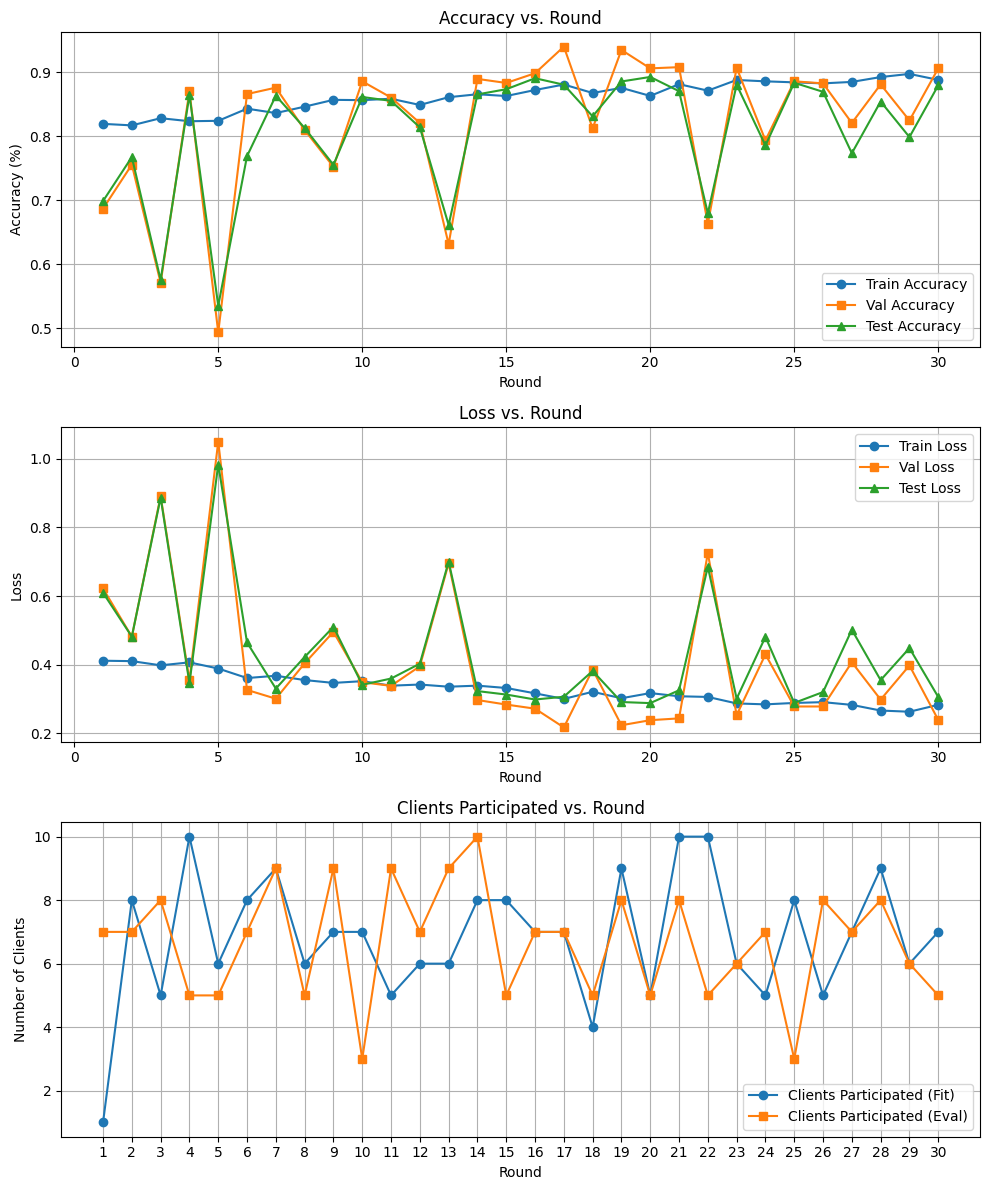

In [38]:
plt.figure(figsize=(10, 12))

# Biểu đồ Accuracy
plt.subplot(3, 1, 1)
plt.plot(range(1, len(metrics["train_accuracy"]) + 1), metrics["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(1, len(metrics["val_accuracy"]) + 1), metrics["val_accuracy"], label="Val Accuracy", marker='s')
plt.plot(range(1, len(metrics["test_accuracy"]) + 1), metrics["test_accuracy"], label="Test Accuracy", marker='^')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Loss
plt.subplot(3, 1, 2)
plt.plot(range(1, len(metrics["train_loss"]) + 1), metrics["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, len(metrics["val_loss"]) + 1), metrics["val_loss"], label="Val Loss", marker='s')
plt.plot(range(1, len(metrics["test_loss"]) + 1), metrics["test_loss"], label="Test Loss", marker='^')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Clients Participated
plt.subplot(3, 1, 3)
plt.plot(range(1, len(metrics["clients_participated_fit"]) + 1), metrics["clients_participated_fit"], label="Clients Participated (Fit)", marker='o')
plt.plot(range(1, len(metrics["clients_participated_eval"]) + 1), metrics["clients_participated_eval"], label="Clients Participated (Eval)", marker='s')
plt.xlabel("Round")
plt.ylabel("Number of Clients")
plt.title("Clients Participated vs. Round")
plt.legend()
plt.grid(True)
plt.xticks(range(1, max(len(metrics["clients_participated_fit"]), len(metrics["clients_participated_eval"])) + 1))

plt.tight_layout()


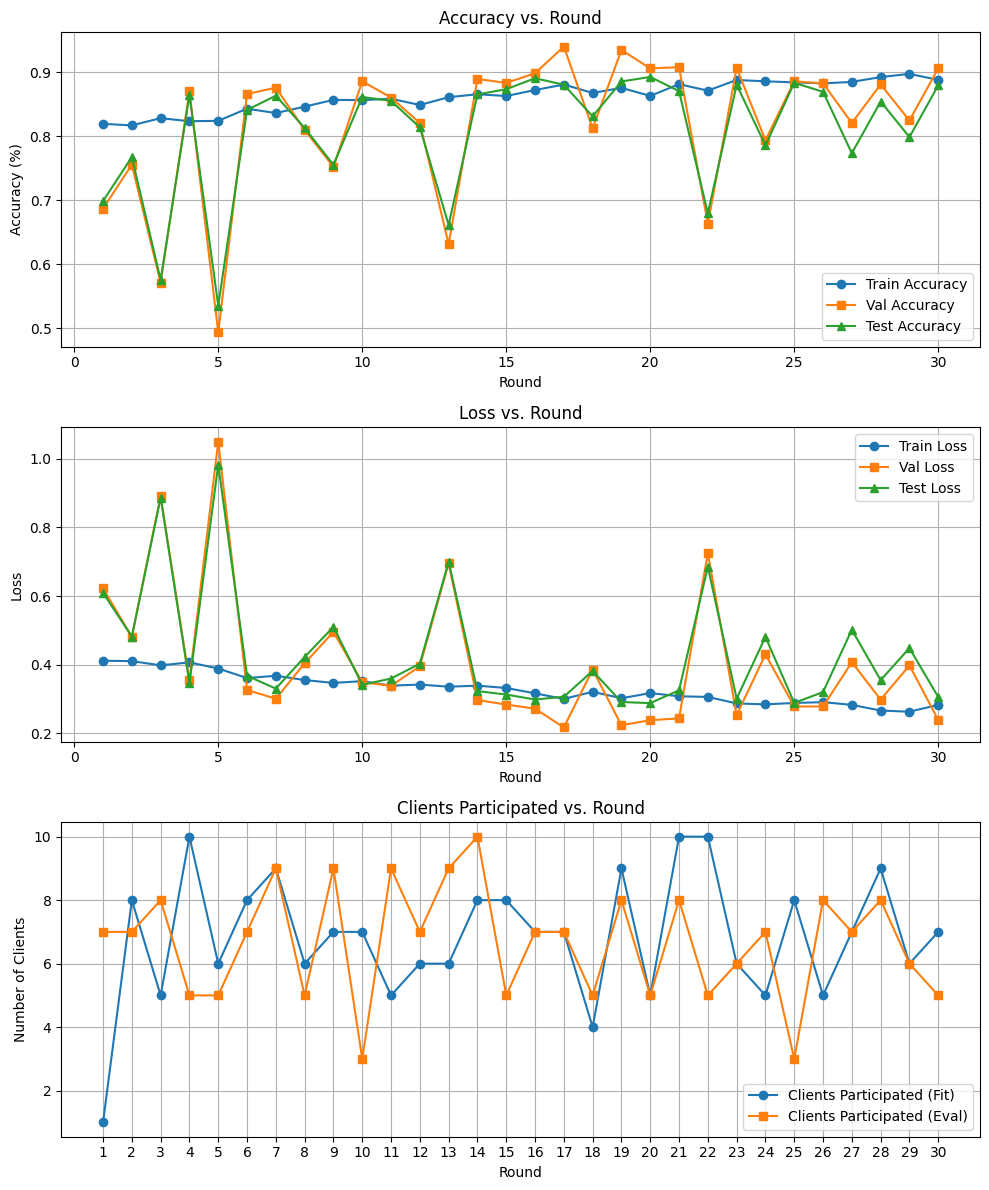

In [28]:
plt.figure(figsize=(10, 12))

# Biểu đồ Accuracy
plt.subplot(3, 1, 1)
plt.plot(range(1, len(HISTORY["train_accuracy"]) + 1), HISTORY["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(1, len(HISTORY["val_accuracy"]) + 1), HISTORY["val_accuracy"], label="Val Accuracy", marker='s')
plt.plot(range(1, len(HISTORY["test_accuracy"]) + 1), HISTORY["test_accuracy"], label="Test Accuracy", marker='^')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Loss
plt.subplot(3, 1, 2)
plt.plot(range(1, len(HISTORY["train_loss"]) + 1), HISTORY["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, len(HISTORY["val_loss"]) + 1), HISTORY["val_loss"], label="Val Loss", marker='s')
plt.plot(range(1, len(HISTORY["test_loss"]) + 1), HISTORY["test_loss"], label="Test Loss", marker='^')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Clients Participated
plt.subplot(3, 1, 3)
plt.plot(range(1, len(HISTORY["clients_participated_fit"]) + 1), HISTORY["clients_participated_fit"], label="Clients Participated (Fit)", marker='o')
plt.plot(range(1, len(HISTORY["clients_participated_eval"]) + 1), HISTORY["clients_participated_eval"], label="Clients Participated (Eval)", marker='s')
plt.xlabel("Round")
plt.ylabel("Number of Clients")
plt.title("Clients Participated vs. Round")
plt.legend()
plt.grid(True)
plt.xticks(range(1, max(len(HISTORY["clients_participated_fit"]), len(HISTORY["clients_participated_eval"])) + 1))

plt.tight_layout()